# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally.

In [4]:
!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

In [97]:
!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.6/167.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.5/166.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 7.5 MB/s eta 0:00:00


We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [5]:
!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [89]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

Enter your OpenAI API Key:··········


In [90]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

Cohere API Key:··········


In [91]:
os.environ["RAGAS_APP_TOKEN"] = getpass.getpass("Please enter your Ragas API key!")


Please enter your Ragas API key!··········


In [92]:

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [7]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-03-03 23:11:41--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.001s  

2025-03-03 23:11:41 (23.2 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-03-03 23:11:41--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [8]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [9]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 2, 28, 23, 11, 47, 510719)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [12]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [13]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [14]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [15]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [16]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [17]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the positive reviews and high ratings it received.'

In [18]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'"

In [19]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, an ex-hitman comes out of retirement to seek vengeance against the gangsters that killed his dog and took everything from him. As the story unfolds, John Wick unleashes a maelstrom of destruction against those who come after him, leading to intense shootouts and breathtaking fights. The movie is known for its violent and gripping story with plenty of nonstop action.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [20]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [21]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [22]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'While opinions on the John Wick series vary, some people enjoyed the action and style of the movies, while others found certain installments lacking in plot or substance. It ultimately depends on individual preferences.'

In [23]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I don't know."

In [24]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character, played by Keanu Reeves, goes on a revenge mission after the death of his dog, which was given to him by his deceased wife. The action is beautifully choreographed and the setup is emotional. It is highly praised for its action sequences and overall entertainment value.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [25]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [26]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [27]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick. The reviews highlighted the slickness of Keanu Reeves' performance, the brilliance of the action sequences, and the overall enjoyment of the film, making it a highly recommended movie for action fans."

In [28]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for "John Wick 3." Here is the URL for that review: \'/review/rw4854296/?ref_=tt_urv\''

In [29]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, after resolving issues with the Russian mafia, John Wick is visited by mobster Santino D'Antonio who asks for his help. When John refuses, Santino blows up his house. Eventually, John is tasked with killing Santino's sister in Rome, leading to a contract being put on him. John promises to kill Santino in return."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [30]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [31]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [32]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the positive reviews provided.'

In [33]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Based on the context provided, there is a review for "John Wick 3" with a rating of 10. Here is the URL for that review: \'/review/rw4854296/?ref_=tt_urv\'. \n\nUnfortunately, there are no reviews for "John Wick 4" with a rating of 10 in the provided context.'

In [34]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the story follows retired assassin John Wick who gets pulled back into the world of violence when someone kills his dog and steals his car, leading to a lot of carnage. Later on, John is called to pay off an old debt by helping take over the Assassin's Guild in various locations by killing many assassins."

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [35]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [37]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [38]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [39]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [40]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [41]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, opinions about "John Wick 4" seem to be split. Some people really enjoyed the movie and thought it was the best in the series, while others did not like it at all. So, it is safe to say that the reception of "John Wick 4" among people varies.'

In [42]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review that has a rating of 10. Here is the URL to that review: /review/rw4854296/?ref_=tt_urv'

In [43]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, a retired assassin named John Wick comes out of retirement when someone kills his dog. In the second movie, John is called to pay off an old debt by helping take over the Assassin's Guild by traveling to Italy, Canada, and Manhattan and killing numerous assassins."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [45]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [46]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [47]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally enjoyed John Wick based on the reviews provided.'

In [48]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'"

In [49]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," the main character, a retired hitman named John Wick, seeks revenge after gangsters kill his dog and steal his car. This sets off a chain of violent events as he goes after those responsible. His quest for vengeance leads to intense action sequences and numerous encounters with other assassins and criminals.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [50]:
!pip install -qU langchain_experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 3.3 MB/s eta 0:00:00


We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [51]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [52]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [53]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [54]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [55]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [56]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, most people seem to have enjoyed the John Wick movies.'

In [57]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is one review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'"

In [58]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character seeks revenge on the people who took something he loved from him, which was his dog. This sets off a chain of events where John Wick goes on a mission of vengeance against those who wronged him.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [62]:
pip install -qU ragas==0.2.10


In [64]:
pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.2 MB/s eta 0:00:00


In [65]:
### YOUR CODE HERE

from ragas.testset import TestsetGenerator

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(documents, testset_size=10)







Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [66]:
dataset.to_pandas()


,user_input,reference_contexts,reference,synthesizer_name
0,How does the film 'John Wick' maintain origina...,[: 0\nReview: The best way I can describe John...,The film 'John Wick' maintains originality and...,single_hop_specifc_query_synthesizer
1,What prompted the critic to finally watch 'Joh...,[: 2\nReview: With the fourth installment scor...,The critic decided to check out 'John Wick' af...,single_hop_specifc_query_synthesizer
2,What makes the action sequences in John Wick s...,[: 3\nReview: John wick has a very simple reve...,The action sequences in John Wick stand out du...,single_hop_specifc_query_synthesizer
3,Wut makes Jonh Wick such an exciting action fi...,[: 4\nReview: Though he no longer has a taste ...,John Wick is exciting for action film enthusia...,single_hop_specifc_query_synthesizer
4,How does the portrayal of Russian characters c...,[: 5\nReview: Ultra-violent first entry with l...,"In the original John Wick (2014), the narrativ...",single_hop_specifc_query_synthesizer
5,Why John Wick 3 best action movie and how it c...,[<1-hop>\n\n: 16\nReview: John Wick 3 is witho...,John Wick 3 is considered the best action movi...,multi_hop_specific_query_synthesizer
6,How do the reviews of John Wick 3 and John Wic...,[<1-hop>\n\n: 16\nReview: John Wick 3 is witho...,The review of John Wick 3 praises it as the be...,multi_hop_specific_query_synthesizer
7,What are the contrasting opinions on the John ...,[<1-hop>\n\n: 11\nReview: JOHN WICK is a rare ...,The John Wick series is generally praised for ...,multi_hop_specific_query_synthesizer
8,In what ways does the first John Wick film exe...,[<1-hop>\n\n: 11\nReview: JOHN WICK is a rare ...,The first John Wick film is praised as a near-...,multi_hop_specific_query_synthesizer
9,In what ways does 'John Wick: Chapter 3 - Para...,"[<1-hop>\n\n: 21\nReview: ..THE FILM-MAKERS, {...",'John Wick: Chapter 3 - Parabellum' explores t...,multi_hop_specific_query_synthesizer


If you've provided your Ragas API key - you can use this web interface to look at the created data!



In [70]:
dataset.upload()


Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/aaca2042-614b-4fb5-aa04-29c93324c6d7


'https://app.ragas.io/dashboard/alignment/testset/aaca2042-614b-4fb5-aa04-29c93324c6d7'

Define retrieval chain to evaluate

In [71]:
retrieval_chain = {
    "Naive": naive_retrieval_chain,
    "BM25": bm25_retrieval_chain,
    "Multi-Query": multi_query_retrieval_chain,
    "Parent-Document": parent_document_retrieval_chain,
    "Contextual Compression": contextual_compression_retrieval_chain,
    "Ensemble": ensemble_retrieval_chain,
    "Semantic": semantic_retrieval_chain
}

**Run evaluations**

We'll need to select a judge model - in this case we're using the same model that was used to generate our Synthetic Data.



In [102]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas import EvaluationDataset, evaluate, RunConfig
from ragas.metrics import (
    LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
)
import pandas as pd
from langchain_core.messages import AIMessage
from ragas.cost import get_token_usage_for_openai


# Evaluation model
evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

#Custom run config
custom_run_config = RunConfig(timeout=360)

# Retrieval results
retrieval_results = {}
tokens = {}

# Evaluate each retrieval chain
for name, chain in retrieval_chain.items():
  print(f"Evaluating {name}")

  for test_row in dataset:
    response = chain.invoke({"question" : test_row.eval_sample.user_input})
    test_row.eval_sample.response = (
            response["response"].content if isinstance(response["response"], AIMessage) else str(response["response"])
        )
    test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

  # Convert dataset to EvaluationDataset format
  evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

  # Run evaluation
  result = evaluate(
      dataset=evaluation_dataset,
      metrics=[
          LLMContextRecall(),
          Faithfulness(),
          FactualCorrectness(),
          ResponseRelevancy(),
          ContextEntityRecall(),
          NoiseSensitivity()
      ],
      llm=evaluator_llm,
      run_config=custom_run_config,
      token_usage_parser=get_token_usage_for_openai
  )

  retrieval_results[name] = result
  tokens[name] = result.total_tokens()
  print(f"Finished evaluating {name}")

# convert retrieval_results to dataframe
retrieval_results_df = pd.DataFrame.from_dict(retrieval_results, orient='index')
retrieval_results_df.to_csv("retrieval_results.csv")

# Display retrieval_results_df
retrieval_results_df




Evaluating Naive


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[5]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[53]: TimeoutError()


Finished evaluating Naive
Evaluating BM25


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[32]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')


Finished evaluating BM25
Evaluating Multi-Query


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[5]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[23]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[29]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[35]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[47]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[53]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[59]: TimeoutError()


Finished evaluating Multi-Query
Evaluating Parent-Document


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Finished evaluating Parent-Document
Evaluating Contextual Compression


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

Finished evaluating Contextual Compression
Evaluating Ensemble


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[5]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[17]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[23]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[29]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[35]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[47]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[53]: TimeoutError()


Finished evaluating Ensemble
Evaluating Semantic


Evaluating:   0%|          | 0/60 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[53]: TimeoutError()


Finished evaluating Semantic


,scores,dataset,binary_columns,cost_cb,traces,ragas_traces,run_id
Naive,"[{'context_recall': 1.0, 'faithfulness': 0.875...","{'samples': [user_input=""How does the film 'Jo...",[],<ragas.cost.CostCallbackHandler object at 0x79...,"[{'scores': {'context_recall': 1.0, 'faithfuln...",{'b374e216-8c15-43ce-a984-d97c8e65dd0d': run_i...,None
BM25,"[{'context_recall': 0.6666666666666666, 'faith...","{'samples': [user_input=""How does the film 'Jo...",[],<ragas.cost.CostCallbackHandler object at 0x79...,[{'scores': {'context_recall': 0.6666666666666...,{'743935f0-4bc3-4166-ab84-a8d0899e1b57': run_i...,None
Multi-Query,"[{'context_recall': 1.0, 'faithfulness': 0.8, ...","{'samples': [user_input=""How does the film 'Jo...",[],<ragas.cost.CostCallbackHandler object at 0x79...,"[{'scores': {'context_recall': 1.0, 'faithfuln...",{'89079530-9ca6-4809-8c02-f06e286436b7': run_i...,None
Parent-Document,"[{'context_recall': 0.3333333333333333, 'faith...","{'samples': [user_input=""How does the film 'Jo...",[],<ragas.cost.CostCallbackHandler object at 0x79...,[{'scores': {'context_recall': 0.3333333333333...,{'2af4c2f1-9223-4661-a0a7-268fe7152171': run_i...,None
Contextual Compression,"[{'context_recall': 0.6666666666666666, 'faith...","{'samples': [user_input=""How does the film 'Jo...",[],<ragas.cost.CostCallbackHandler object at 0x79...,[{'scores': {'context_recall': 0.6666666666666...,{'ca7760d7-8f3e-4929-9228-7225e840b24b': run_i...,None
Ensemble,"[{'context_recall': 1.0, 'faithfulness': 1.0, ...","{'samples': [user_input=""How does the film 'Jo...",[],<ragas.cost.CostCallbackHandler object at 0x79...,"[{'scores': {'context_recall': 1.0, 'faithfuln...",{'62c61bea-b993-4691-a77c-18fe33f825e0': run_i...,None
Semantic,"[{'context_recall': 1.0, 'faithfulness': 0.8, ...","{'samples': [user_input=""How does the film 'Jo...",[],<ragas.cost.CostCallbackHandler object at 0x79...,"[{'scores': {'context_recall': 1.0, 'faithfuln...",{'8a310e29-7ef7-4c05-ad8d-7135d70cc0ee': run_i...,None


In [75]:

# convert retrieval_results to dataframe
retrieval_results_df = pd.DataFrame.from_dict(retrieval_results, orient='index')
retrieval_results_df.to_csv("retrieval_results.csv")



In [76]:
display(retrieval_results)

{'Naive': {'context_recall': 0.8167, 'faithfulness': 0.8018, 'factual_correctness': 0.4650, 'answer_relevancy': 0.8758, 'context_entity_recall': 0.3652, 'noise_sensitivity_relevant': 0.3709},
 'BM25': {'context_recall': 0.3583, 'faithfulness': 0.7113, 'factual_correctness': 0.3250, 'answer_relevancy': 0.7703, 'context_entity_recall': 0.3712, 'noise_sensitivity_relevant': 0.2766},
 'Multi-Query': {'context_recall': 0.8000, 'faithfulness': 0.8332, 'factual_correctness': 0.4820, 'answer_relevancy': 0.9694, 'context_entity_recall': 0.4129, 'noise_sensitivity_relevant': 0.0000},
 'Parent-Document': {'context_recall': 0.4833, 'faithfulness': 0.6562, 'factual_correctness': 0.3880, 'answer_relevancy': 0.8720, 'context_entity_recall': 0.4137, 'noise_sensitivity_relevant': 0.2754},
 'Contextual Compression': {'context_recall': 0.5667, 'faithfulness': 0.8862, 'factual_correctness': 0.3920, 'answer_relevancy': 0.9655, 'context_entity_recall': 0.4069, 'noise_sensitivity_relevant': 0.3859},
 'Ensemb

In [103]:
display(tokens)

{'Naive': TokenUsage(input_tokens=426909, output_tokens=134248, model=''),
 'BM25': TokenUsage(input_tokens=266729, output_tokens=63950, model=''),
 'Multi-Query': TokenUsage(input_tokens=475721, output_tokens=139381, model=''),
 'Parent-Document': TokenUsage(input_tokens=242279, output_tokens=59624, model=''),
 'Contextual Compression': TokenUsage(input_tokens=271958, output_tokens=71710, model=''),
 'Ensemble': TokenUsage(input_tokens=570158, output_tokens=193120, model=''),
 'Semantic': TokenUsage(input_tokens=442836, output_tokens=153331, model='')}

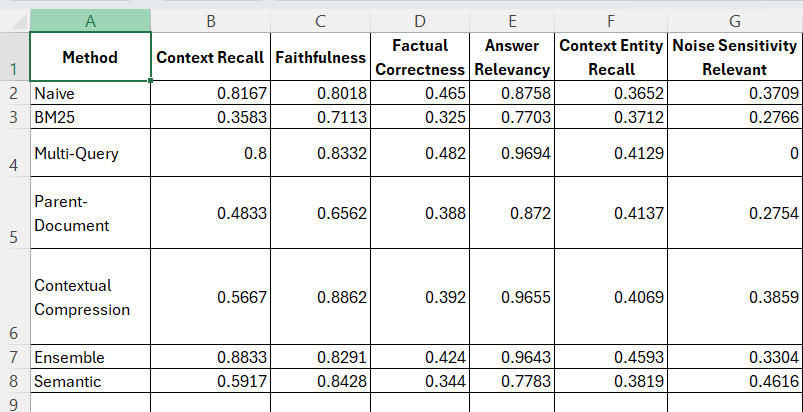

Context Recall:
The Ensemble retriever performed best followed by Naive for the context recall. This can be because an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm. So the number of relevant documents sucessfully retrieved in case on Ensemble Retriever is higher in number.

Faithfulness:
Contextual compression performed best followed by Semantic retriever. This can be because contextual compression retrieves lots of documents that are likely related to our query vector. These documents are then compressed into a small set of more related documents using reranking algorithm. Due to this the response is more factually consistent with the retrieved context.

Factual correctness:
Multi query retriever performed best followed by naive though both the scores could hav ebeen mouch higher.

Answer relevancy:
Multi query, contextual compression and ensembe performed best. The evaluation metric, Answer Relevancy, focuses on assessing how pertinent the generated answer is to the given prompt.

Context Entity Recall:
Ensemble has highest value among all retrievers but all the values for context entity recall are low.

Noise sensitivity relevant: Low value is considered good and indicates better performance. Noise sensitivity for Multi Query retriever is 0.


Conclusion:
Ensember and naive performed good.



You can compute the cost for each run by passing in the cost per token to Result.total_cost() function.

In this case GPT-4o costs $5 for 1M input tokens and $15 for 1M output tokens.

result.total_cost(cost_per_input_token=5 / 1e6, cost_per_output_token=15 / 1e6)

So, using the above formula, here are the costs for each retriever:

Naive: $4.15

BM25: $2.29

Multi-Query: $4.47

Parent-Document: $2.11

Contextual Compression: $2.44

Ensemble: $5.75

Semantic: $4.51

The biggest cost is in case of Ensemble retriever and is loest in case of Parent-Document retriever.